> **DO NOT EDIT IF INSIDE tsds folder**


# Week 3: Artificial Neural Networks 2

*Wednesday, February 19, 2019*

Today, you will complete your understanding of Nielsen's code by understanding how backpropagation is implemented. Then you will move on to problems about regularization in neural networks and something we call "the vanishing gradient problem".
- Part 3.1: Backpropagation
- Part 3.2: Regularization
- Part 3.3: Vanishing gradients

**Questions**: Outside of class, use [issue](https://github.com/abjer/tsds/issues) on GitHub for asking questions.

In [153]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
import mnist_loader
from datetime import datetime as dt

## Exercises

### Part 3.1: Backpropagation

Last week I introduced you to [Nielsen's](http://neuralnetworksanddeeplearning.com/chap1.html) general implementation of a feed forward neural network. **Your understanding** of neural networks should now be something along the lines of: (1) a datapoint propagates forward through the network, then (2) a cost (how bad the prediction is) is evaluated and its gradient wrt. each weight is computed, and finally (3) the weights are updated according to how much they influence the cost.

However, something important is missing from our understanding at this point. Remember, that *gradient descent* – the algorithm for minimizing the cost function, which we can think of as ball rolling downhill – needs to known which direction is downhill on the cost function. The gradient tells us this. **So how do we compute the cost function's gradient?** Enter: *backpropagation*. Backpropagation is an algorithm which computes the gradient of the cost function wrt. each weight in the network, from right to left, by iteratively applying *the chain rule*. It is called *back*-propagation because it propagates gradients *back*-wards in this fashion.

#### Pen and paper calculations

First, I want you to do some pen and paper calculations to hand-compute gradients in a real neural network.

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

> **Ex. 3.1.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net_compgraph_forward.png)

> **Ex. 3.1.2**: Knowing about backpropagation, we actually have everything we need here to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*

#### Understanding the code implementation

I've copied my version of Nielsen's code below. It's an **exact copy** from last week, except I've removed by previous `#Q:` comments and inserted some new ones. In the exercises below you will have to figure out what the `backprop` method is doing, and compute some gradients for very simple neural networks with pen and paper.

In [47]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Q: In the feed forward step it seems like we are storing all the
        # intermediate values. Why?
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        
        # Q: What does the variable `delta` store? Why is the last bias gradient
        # exactly `delta`?
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        
        # Q: Seems like we are multiplying each of the outputs from the previous
        # layer, with the delta. Can you explain why we do this? 
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        
        # Q: Why start the loop at the second last layer?
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp  # Q: What happens on this line?
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

> **Ex. 3.1.1:** Provide answers to the code comments starting with `#Q: `

In [138]:
# Q: In the feed forward step it seems like we are storing all the
# intermediate values. Why?

As we saw in the lecture, the fed forward valued are used as input to the derivarive of each neuron, so we need to store them in order to compute the gradients when we do backpropagation.

In [ ]:
# Q: What does the variable `delta` store? Why is the last bias gradient
# exactly `delta`?

At this point in the code and onwarsd, `delta` is the gradient of the loss function wrt. the weight/neuron-output that the iteration of the backprop algorithm has reached. In the first iteration of backprop that Nielsen implements, he computed the `delta`(s) of the value(s) that goes into the last sigmoid. The multiplication between the cost derivative (where the cost derivative is missing a `2*`, who knows why), and the sigmoid derivative is Nielsen applying the chain rule. Note also that `delta` is a vector, such that if multiple outputs existed (and they do in the case of number classification), you compute a gradient for each output neuron. Finally, as you may recall from the lecture, the derivative of addition operators are 1, so the gradient of the bias(es) just becomes the gradient of the output(s).

In [139]:
# Q: Seems like we are multiplying each of the outputs from the previous
# layer, with the delta. Can you explain why we do this? 

Remember how the derivative of a weight is the variable multiplied onto it? This is what Nielsen utilizes here. Given the derivative(s) from the output(s), we know that the derivative of an output wrt. a weight is just the input which we multiply that weight by. Think of it like "if I increment this weight by one, the output gets changed by the amount that I multiply the weight by". So to propagate the gradient backwards and onto the first layer of weights, we simply multiply it by the incoming activations.

In [140]:
# Q: Why start the loop at the second last layer?

So this loop iteratively applies what I just explained above. And there we already handled the last layer, remember? So we start off where we left.

In [141]:
# Q: What happens on this line?

We are computing the gradients on the neuron-outputs (the `z`s) going into the sigmoids of the given layer.
So to do that we must take the previous gradient and multiply it with the weights (remember $y=xw$), then
multiply again by the derivative of the sigmoid function. This new delta, as we saw above, propagates back
to the bias without complication – since the bias derivative wrt. to the output of the neuron it feeds into
is one. To get the weight gradients the gradient, as before, gets multiplied, by the activations from the
incoming layers. The new gradients get stored, and so it goes until we run out of layers.

### Part 3.2: Regularization

For this next part, it would be too cumbersome to continue using Nielsen's code. Instead, we will be using
my favorite deep learning framework **PyTorch** to build some neural networks with which we can play around
with regularization.

To get torch running you need to first install it. It's should be fairly straight forward, but depending on
your machine you may have to run different commands to install it. Check out the installation guide [here](https://pytorch.org/).

If everything went well you should be able execute the cell below and to import PyTorch.

In [11]:
import torch

No errors? Great! Then let's make a small neural network that we know all to well at this point, and see if we can classify points with it. First, we generate some data.

In [92]:
def generate_X_nonlinear(N=200, R=5):

    X_inner = torch.randn(int(N/2), 2)

    X_outer = torch.tensor([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + torch.randn(int(N/2), 2)

    X = torch.cat([X_inner, X_outer], dim=0)
   
    y = torch.cat([
        torch.zeros(int(N/2)).reshape(-1, 1),
        torch.ones(int(N/2)).reshape(-1, 1)
    ])
    
    return X, y

# Number of training datapoints
N = 500

# Generate the data (note that code is using torch arrays now)
x, y = generate_X_nonlinear(N)

And then we create and run the network on the data.

In [93]:
# The layers and their number of neurons
sizes = [2, 3, 1]

# The `model`. This is new! In torch, defining a neural network is a easy as just
# declaring which layers you want, and then it handles everything else. So in this
# case we want a linear layer that gets squashed through a sigmoid, which feeds as
# input to another layer that again gets squashed by a sigmoid.
model = torch.nn.Sequential(
    torch.nn.Linear(sizes[0], sizes[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(sizes[1], sizes[2]),
    torch.nn.Sigmoid()
)

# Then we have to declare which loss function we want to use, and here we are just goind

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-1
for t in range(100):
    # Forward pass
    y_pred = model(x)

    # Compute loss
    loss = loss_fn(y_pred, y)
    if t % 10 == 0:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass
    loss.backward()

    # Do gradient descent
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 132.64141845703125
10 243.86502075195312
20 74.21397399902344
30 20.397912979125977
40 10.828099250793457
50 8.089787483215332
60 7.727997779846191
70 7.685032844543457
80 7.67869234085083
90 7.663687229156494


And let's visualize the results

In [94]:
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 1])
    >>> cmap(0.1)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

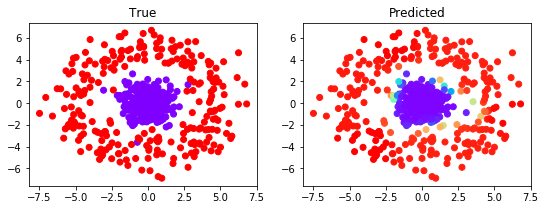

In [95]:
cmap = cmap_in_range([0, 1])

y_true = y.reshape(-1).numpy()
y_pred = model(x).data.numpy().reshape(-1)

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("True", fontsize=12)
plt.scatter(x[:, 0], x[:, 1], color=list(map(cmap, y_true)))

plt.subplot(1, 2, 2)
plt.title("Predicted", fontsize=12)
plt.scatter(x[:, 0], x[:, 1], color=list(map(cmap, y_pred)))
plt.show()

The PyTorch API for setting up and training neural nets is much nicer than Nielsen's code,
and at the same time it runs much faster and seems to give better results.
Let's implement the MNIST example in PyTorch and see how well it performs.

In [161]:
# Load MNIST data. Note we use the `load_data` method and not the 
# `load_data_wrapper`. The difference is that `load_data` gives us
# the data in clean matrix format right away.
training_data, validation_data, test_data = mnist_loader.load_data()

x = torch.from_numpy(training_data[0])
y_ = torch.from_numpy(training_data[1])

x_test = torch.from_numpy(test_data[0])
y_test_ = torch.from_numpy(test_data[1])

# y is a (N, 1) vector. In the following setup, however, we need it to be a
# (N, 10) vector such that each digit has it's own column so labels are one-
# hot vectors. For example, we should encode the label `2` not as [2], but as
# [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] instead.

y = torch.zeros(x.shape[0], 10)
y[torch.arange(x.shape[0]), y_] = 1

y_test = torch.zeros(x_test.shape[0], 10)
y_test[torch.arange(x_test.shape[0]), y_test_] = 1

In [166]:
# Parameters
sizes = [784, 30, 10]
learning_rate = 1e-4
epochs = 1000
# mini_batch_size = 100
tmax = 20  # seconds

# The `model`. This is new! In torch, defining a neural network is a easy as just
# declaring which layers you want, and then it handles everything else. So in this
# case we want a linear layer that gets squashed through a sigmoid, which feeds as
# input to another layer that again gets squashed by a sigmoid. If we needed more
# layers we would put more stuff into the `torch.nn.Sequential` method.
model = torch.nn.Sequential(
    torch.nn.Linear(sizes[0], sizes[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(sizes[1], sizes[2]),
    torch.nn.Sigmoid()
)

# Then we have to declare which loss function we want to use, and here we are just going
# to use the sum of squares. Here we are just taking an implementation of this off the
# shelf from the PyTorch package, but we could easily define one ourself.
loss_fn = torch.nn.MSELoss(reduction='sum')

# Define an Optimizer to abstract away all the steps involved in training the network 
# (forward pass, backward pass, weight update). Here we use the Adam optimizer, which
# is a flavor of gradient descent that maintains an adaptive learning rate for each weight
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
t_start = dt.now()
for t in range(epochs):
    
    # Forward pass
    y_pred = model(x)

    # Compute loss
    loss = loss_fn(y_pred, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers (i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Print progress
    if t % 10 == 0:
        y_pred = model(x_test)
        loss_test = loss_fn(y_pred, y_test)
        print(t, "train:", loss.item(), "| test:", loss_test.item())
        if (dt.now() - t_start).seconds > tmax:
            break

0 train: 127307.8984375 | test: 25383.9296875
10 train: 123641.0078125 | test: 24648.4375
20 train: 120118.7890625 | test: 23942.80078125
30 train: 116761.7421875 | test: 23270.98046875
40 train: 113579.90625 | test: 22634.814453125
50 train: 110574.4296875 | test: 22034.376953125
60 train: 107740.21875 | test: 21468.51953125
70 train: 105068.40625 | test: 20935.369140625
80 train: 102548.2421875 | test: 20432.7109375
90 train: 100168.4453125 | test: 19958.236328125
100 train: 97917.8828125 | test: 19509.685546875
110 train: 95786.0390625 | test: 19084.93359375
120 train: 93763.203125 | test: 18682.01953125
130 train: 91840.5234375 | test: 18299.1640625
140 train: 90010.015625 | test: 17934.759765625
150 train: 88264.5390625 | test: 17587.369140625
160 train: 86597.6953125 | test: 17255.712890625
170 train: 85003.8359375 | test: 16938.646484375
180 train: 83477.90625 | test: 16635.162109375
190 train: 82015.453125 | test: 16344.3564453125
200 train: 80612.46875 | test: 16065.427734375


This code will run for a while, and it's not nearly as fast as it could be. The reason for 
this is that it is not using mini batches, thus it is doing gradient descent on the entire
dataset. That takes time 

**Note: The "solutions" below are more like explorations where I play with mini-batching and regularization in different ways. I encourage you to use them in the same way, so to get an idea of what I did. Play with the parameters, let the networks train for much longer than I did and build a practical sense of what happens when we twist these knobs.**

> **Ex. 3.2.1**: Implement stochastic gradient descent with `mini_batch_size = 100`. Comment on the performance difference you see when compared to regular gradient descent.
>
> *Hint: If you want to compute the accuracy, you need to convert the predictions back into a single column label vector and compare it with the true labels. Here is how to do that: `_, y_pred_ = y_pred.max(1); print((y_pred_ == y_).numpy().mean())`*

In [167]:
# Parameters
sizes = [784, 30, 10]
learning_rate = 1e-4
epochs = 1000
mini_batch_size = 100
tmax = 20  # seconds

# The `model`. This is new! In torch, defining a neural network is a easy as just
# declaring which layers you want, and then it handles everything else. So in this
# case we want a linear layer that gets squashed through a sigmoid, which feeds as
# input to another layer that again gets squashed by a sigmoid. If we needed more
# layers we would put more stuff into the `torch.nn.Sequential` method.
model = torch.nn.Sequential(
    torch.nn.Linear(sizes[0], sizes[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(sizes[1], sizes[2]),
    torch.nn.Sigmoid()
)

# Then we have to declare which loss function we want to use, and here we are just going
# to use the sum of squares. Here we are just taking an implementation of this off the
# shelf from the PyTorch package, but we could easily define one ourself.
loss_fn = torch.nn.MSELoss(reduction='sum')

# Define an Optimizer to abstract away all the steps involved in training the network 
# (forward pass, backward pass, weight update). Here we use the Adam optimizer, which
# is a flavor of gradient descent that maintains an adaptive learning rate for each weight
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
t_start = dt.now()
for t in range(epochs):
    
    # Randomly permute the row indices to get something like:
    # tensor([16214, 18491, 16308,  ..., 19629, 17565, 24696])
    permutation = torch.randperm(x.size()[0])
    
    # Start looping over the mini-batches! Each index `k` is
    # `mini_batch_size` values apart.
    for k in np.arange(0, x.size()[0], mini_batch_size):
        
        # Extract mini-batch data. The rest is the same
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = x[mini_batch_indices, :]
        y_ = y[mini_batch_indices, :]
        
        # Forward pass
        y_pred = model(x_)

        # Compute loss
        loss = loss_fn(y_pred, y_)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers (i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        
    # Print progress (here evaluating on all the data so we can compare)
    if t % 10 == 0:
        loss = loss_fn(model(x), y)
        loss_test = loss_fn(model(x_test), y_test)
        print(t, "train:", loss.item(), "| test:", loss_test.item())
        if (dt.now() - t_start).seconds > tmax:
            break

0 train: 55400.0625 | test: 11061.724609375
10 train: 20146.51171875 | test: 3963.51318359375
20 train: 10417.4833984375 | test: 2010.6806640625
30 train: 7913.51953125 | test: 1533.88525390625
40 train: 6821.16796875 | test: 1336.722412109375
50 train: 6162.6748046875 | test: 1220.811767578125


So here, I let the code above without mini-batching and the new code *with* mini-batching each run for 20 seconds
and compare the error. Without mini-batching we can run through many more *epochs* than with mini-batching, but
the cost is very high after 20 seconds, whereas when we implement mini-batching, **the cost decays extremely fast**,
and **over fewer epochs**. Nice right!? Note that I've slightly changed the code, so it now prints performance on
the test data.

We can apply the L2 regularization to the optimization by specifying a `weight_decay` parameter in the optimizer ([see docs](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)). 

> **Ex. 3.2.2**: When applying the L2 norm, say at `weight_decay=0.2` and changing nothing else, which changes to optimization speed and convergence do you notice?

In [168]:
# Parameters
sizes = [784, 30, 10]
learning_rate = 1e-4
epochs = 1000
mini_batch_size = 100
tmax = 20  # seconds

# The `model`. This is new! In torch, defining a neural network is a easy as just
# declaring which layers you want, and then it handles everything else. So in this
# case we want a linear layer that gets squashed through a sigmoid, which feeds as
# input to another layer that again gets squashed by a sigmoid. If we needed more
# layers we would put more stuff into the `torch.nn.Sequential` method.
model = torch.nn.Sequential(
    torch.nn.Linear(sizes[0], sizes[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(sizes[1], sizes[2]),
    torch.nn.Sigmoid()
)

# Then we have to declare which loss function we want to use, and here we are just going
# to use the sum of squares. Here we are just taking an implementation of this off the
# shelf from the PyTorch package, but we could easily define one ourself.
loss_fn = torch.nn.MSELoss(reduction='sum')

# Define an Optimizer to abstract away all the steps involved in training the network 
# (forward pass, backward pass, weight update). Here we use the Adam optimizer, which
# is a flavor of gradient descent that maintains an adaptive learning rate for each weight
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.2)

# Train
t_start = dt.now()
for t in range(epochs):
    
    # Randomly permute the row indices to get something like:
    # tensor([16214, 18491, 16308,  ..., 19629, 17565, 24696])
    permutation = torch.randperm(x.size()[0])
    
    # Start looping over the mini-batches! Each index `k` is
    # `mini_batch_size` values apart.
    for k in np.arange(0, x.size()[0], mini_batch_size):
        
        # Extract mini-batch data. The rest is the same
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = x[mini_batch_indices, :]
        y_ = y[mini_batch_indices, :]
        
        # Forward pass
        y_pred = model(x_)

        # Compute loss
        loss = loss_fn(y_pred, y_)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers (i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        
    # Print progress (here evaluating on all the data so we can compare)
    if t % 10 == 0:
        loss = loss_fn(model(x), y)
        loss_test = loss_fn(model(x_test), y_test)
        print(t, "train:", loss.item(), "| test:", loss_test.item())
        if (dt.now() - t_start).seconds > tmax:
            break

0 train: 62460.171875 | test: 12460.697265625
10 train: 26238.98828125 | test: 5181.84228515625
20 train: 15722.1865234375 | test: 3033.17236328125
30 train: 13200.2705078125 | test: 2527.4931640625
40 train: 12431.6796875 | test: 2375.56689453125


With regularization, we note that the error decays slower. We could run it for longer and we would probably observe
that the training error plateaued at a higher level than without reguarization, while the test error would potentially
improve, though maybe not exactly for `weight_decay = 0.2`, but for some other value. Hence, we could embark on an
elaborate hyper-parameter tuning quest, to find the weight decay constant (from the lecture: $\lambda$) which minimized
the test error. But let's save that for another time.

We can apply dropout to individual layers by having `torch.nn.Dropout(p=my_dropout)` listed in `Sequential` immediately before the given layer.

> **Ex. 3.2.3**: Apply dropout at a rate of 0.5 and comment again on optimization speed and convergence.

In [170]:
# Parameters
sizes = [784, 30, 10]
learning_rate = 1e-4
epochs = 1000
mini_batch_size = 100
tmax = 20  # seconds

# The `model`. This is new! In torch, defining a neural network is a easy as just
# declaring which layers you want, and then it handles everything else. So in this
# case we want a linear layer that gets squashed through a sigmoid, which feeds as
# input to another layer that again gets squashed by a sigmoid. If we needed more
# layers we would put more stuff into the `torch.nn.Sequential` method.
model = torch.nn.Sequential(
    torch.nn.Linear(sizes[0], sizes[1]),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(sizes[1], sizes[2]),
    torch.nn.Sigmoid()
)

# Then we have to declare which loss function we want to use, and here we are just going
# to use the sum of squares. Here we are just taking an implementation of this off the
# shelf from the PyTorch package, but we could easily define one ourself.
loss_fn = torch.nn.MSELoss(reduction='sum')

# Define an Optimizer to abstract away all the steps involved in training the network 
# (forward pass, backward pass, weight update). Here we use the Adam optimizer, which
# is a flavor of gradient descent that maintains an adaptive learning rate for each weight
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
t_start = dt.now()
for t in range(epochs):
    
    # Randomly permute the row indices to get something like:
    # tensor([16214, 18491, 16308,  ..., 19629, 17565, 24696])
    permutation = torch.randperm(x.size()[0])
    
    # Start looping over the mini-batches! Each index `k` is
    # `mini_batch_size` values apart.
    for k in np.arange(0, x.size()[0], mini_batch_size):
        
        # Extract mini-batch data. The rest is the same
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = x[mini_batch_indices, :]
        y_ = y[mini_batch_indices, :]
        
        # Forward pass
        y_pred = model(x_)

        # Compute loss
        loss = loss_fn(y_pred, y_)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers (i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        
    # Print progress (here evaluating on all the data so we can compare)
    if t % 10 == 0:
        loss = loss_fn(model(x), y)
        loss_test = loss_fn(model(x_test), y_test)
        print(t, "train:", loss.item(), "| test:", loss_test.item())
        if (dt.now() - t_start).seconds > tmax:
            break

0 train: 61529.38671875 | test: 12295.806640625
10 train: 30462.8125 | test: 6058.34765625
20 train: 20971.576171875 | test: 4132.5830078125
30 train: 17695.595703125 | test: 3474.6328125
40 train: 16154.3291015625 | test: 3170.207275390625


So with a drop-out on the hidden layer, this high, we have much slower learning in our network.

In general this small network is not optimal for playing with regularization, because it is so small that little regularization is required anyway. Next week, however, we will be working with some networks that very much require regularization in order to not overfit.